# Non linear MPC

https://apmonitor.com/do/index.php/Main/NonlinearControl

Reaction: A --> B
T_C: Temperature jacket
C_A: Concentration of A
T: Temperatura dentro del CSTR  

T nunca > 400 K. 
T_C puede ajustarce entre 250 y 350 K. 

El codigo para producir data_coublet.txt & cstr_step_tests.txt esta en el link de arriba.   

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from gekko import GEKKO
from IPython.display import clear_output

Manipulated variable (MV): T_C  
Control variable (CV): T  # Puede ser tmb C_A

<Axes: xlabel='Time'>

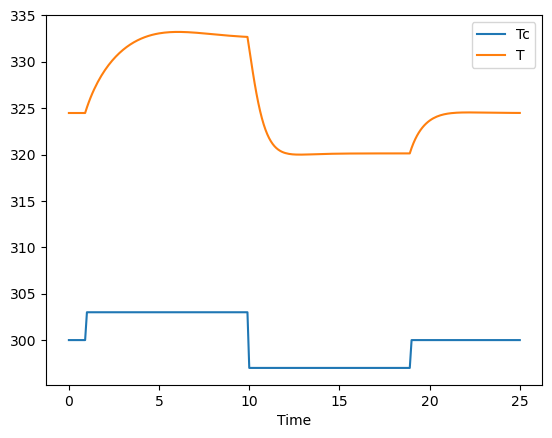

In [2]:

step_test_df = pd.read_csv("./data/data_doublet.txt", index_col='Time')
step_test_df.plot()

En el plot `step_test_df` al principio cuando `T_C` aumenta ~ 3K, `T` aumenta unos 8 K de 325 a unos 333K 

$$K = \frac{\Delta{T}}{\Delta{T_C}} = \frac{8}{3}$$

pero en otras regiones $K = -4/-3$. Es un sistema no linear.   

Si $\tau = 1 \text{ min}$ entonces 

Linear 1st order model:  
$$ \tau \frac{dT}{dt} = - (T - T_{SS}) - K(T_C - T_{C,SS}) $$ 

* $\tau$ es mas o nemos el tiempo de reaccion
* $T_{SS}$ es la temperatura en steady state
* $K$ es "gain"

## La implementacion del PID en GEKKO

In [3]:
#%% define CSTR model
def cstr(x,t,u,Tf,Caf):
    # Inputs (3):
    # Temperature of cooling jacket (K)
    Tc = u
    # Tf = Feed Temperature (K)
    # Caf = Feed Concentration (mol/m^3)

    # States (2):
    # Concentration of A in CSTR (mol/m^3)
    Ca = x[0]
    # Temperature in CSTR (K)
    T = x[1]

    # Parameters:
    # Volumetric Flowrate (m^3/sec)
    q = 100
    # Volume of CSTR (m^3)
    V = 100
    # Density of A-B Mixture (kg/m^3)
    rho = 1000
    # Heat capacity of A-B Mixture (J/kg-K)
    Cp = 0.239
    # Heat of reaction for A->B (J/mol)
    mdelH = 5e4
    # E - Activation energy in the Arrhenius Equation (J/mol)
    # R - Universal Gas Constant = 8.31451 J/mol-K
    EoverR = 8750
    # Pre-exponential factor (1/sec)
    k0 = 7.2e10
    # U - Overall Heat Transfer Coefficient (W/m^2-K)
    # A - Area - this value is specific for the U calculation (m^2)
    UA = 5e4
    # reaction rate
    rA = k0*np.exp(-EoverR/T)*Ca

    # Calculate concentration derivative
    dCadt = q/V*(Caf - Ca) - rA
    # Calculate temperature derivative
    dTdt = q/V*(Tf - T) \
            + mdelH/(rho*Cp)*rA \
            + UA/V/rho/Cp*(Tc-T)

    # Return xdot:
    xdot = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot


In [4]:
# Steady State Initial Condition
u_ss = 280.0
# Feed Temperature (K)
Tf = 350
# Feed Concentration (mol/m^3)
Caf = 1

# Steady State Initial Conditions for the States
Ca_ss = 1
T_ss = 304
x0 = np.empty(2)
x0[0] = Ca_ss
x0[1] = T_ss

#%% GEKKO linear MPC
m = GEKKO(remote=True)
m.time = [0,0.02,0.04,0.06,0.08,0.1,0.15,0.2,0.3,0.4,0.5]

# initial conditions
Tc0 = 280
T0 = 304
Ca0 = 1.0

tau = m.Const(value = 0.5)
Kp = m.Const(value = 1)

m.Tc = m.MV(value = Tc0,lb=250,ub=350)
m.T = m.CV(value = T_ss)

m.Equation(tau * m.T.dt() == -(m.T - T0) + Kp * (m.Tc - Tc0))

#MV tuning
m.Tc.STATUS = 1
m.Tc.FSTATUS = 0
m.Tc.DMAX = 100
m.Tc.DMAXHI = 5   # constrain movement up
m.Tc.DMAXLO = -100 # quick action down
#CV tuning
m.T.STATUS = 1
m.T.FSTATUS = 1
m.T.SP = 330
m.T.TR_INIT = 2
m.T.TAU = 1.0
m.options.CV_TYPE = 2
m.options.IMODE = 6
m.options.SOLVER = 3


# Time Interval (min)
t = np.linspace(0,10,501)

# Store results for plotting
Ca = np.ones(len(t)) * Ca_ss
T = np.ones(len(t)) * T_ss
Tsp = np.ones(len(t)) * T_ss
u = np.ones(len(t)) * u_ss

# Set point steps
Tsp[0:100] = 330.0
Tsp[100:200] = 350.0
Tsp[200:300] = 370.0
Tsp[300:] = 390.0

In [5]:
# Create plot
plt.figure(figsize=(10,7))
plt.ion()
plt.show()

# Simulate CSTR
for i in range(len(t)-1):
    # simulate one time period (0.05 sec each loop)
    ts = [t[i],t[i+1]]
    y = odeint(cstr,x0,ts,args=(u[i],Tf,Caf))
    # retrieve measurements
    Ca[i+1] = y[-1][0]
    T[i+1] = y[-1][1]
    # insert measurement
    m.T.MEAS = T[i+1]
    # update setpoint
    m.T.SP = Tsp[i+1]
    # solve MPC
    m.solve(disp=True)
    # change to a fixed starting point for trajectory
    m.T.TR_INIT = 2
    # retrieve new Tc value
    u[i+1] = m.Tc.NEWVAL
    # update initial conditions
    x0[0] = Ca[i+1]
    x0[1] = T[i+1]

    #%% Plot the results
    plt.clf()
    plt.subplot(3,1,1)
    plt.plot(t[0:i],u[0:i],'b--',lw=3)
    plt.ylabel('Cooling T (K)')
    plt.legend(['Jacket Temperature'],loc='best')

    plt.subplot(3,1,2)
    plt.plot(t[0:i],Ca[0:i],'r-',lw=3)
    plt.ylabel('Ca (mol/L)')
    plt.legend(['Reactor Concentration'],loc='best')

    plt.subplot(3,1,3)
    plt.plot(t[0:i],Tsp[0:i],'k-',lw=3,label=r'$T_{sp}$')
    plt.plot(t[0:i],T[0:i],'b.-',lw=3,label=r'$T_{meas}$')
    plt.ylabel('T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Reactor Temperature'],loc='best')
    plt.draw()
    plt.pause(0.01)
    clear_output(wait=0.5)
plt.show()


apm 77.172.106.167_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            2
   Variables    :            2
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:             90
 Number of total equations: -           80
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             10
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipo